<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/metadata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install holidays

In [218]:
import datetime 
import numpy as np
import holidays
import math
import requests

def epoch_to_utc(hour_in_unix_time):
  return datetime.datetime.utcfromtimestamp(hour_in_unix_time)

def get_month(unix_timestamp):
  return unix_timestamp.month

def get_day(unix_timestamp):
  return unix_timestamp.weekday()

def is_holiday(timestamp):
  uk_holidays = holidays.UK()

  if timestamp in uk_holidays:
    return 1
  else:
    return 0

def rescale(val, in_min, in_max, out_min, out_max):
  return out_min + (val - in_min) * ((out_max - out_min) / (in_max - in_min))

def get_weather(unix_timestamp, size = 100):
  timestamp = str(unix_timestamp)
  key = '00fa20d9a815fab822b59c022ba8f4e5'
  location = '51.87626460000001,-0.3717470999999932'
  exclude = 'exclude=minutely,hourly,daily,alerts,flags'
  units = 'si'
  endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
  response = requests.get(endpoint).json()['currently']

  try:
    temperature = np.reshape(rescale(response['temperature'], -30, 30, 0, 1), (1,1))
  except:
    temperature = np.reshape(rescale(0, -30, 30, 0, 1), (1,1))

  try:
    wind_bearing = np.reshape(response['windBearing']/360, (1,1))
  except:
    wind_bearing = np.reshape(0, (1,1))

  try:
    wind_speed = np.reshape(rescale(response['windSpeed'], 0, 30, 0, 1), (1,1))
  except:
    wind_speed = np.reshape(rescale(0, 0, 30, 0, 1), (1,1))

  try:
    visibility = np.reshape(rescale(response['visibility'], 0, 20, 0, 1), (1,1))
  except:
    visibility = np.reshape(rescale(0, 0, 20, 0, 1), (1,1))

  weather_metadata = np.concatenate((temperature, wind_bearing, wind_speed, visibility), axis = 1)
  return np.tile(weather_metadata, (size, 1))

def metadata(timestamp, size = 100, tiled = True):
  utc_timestamp = epoch_to_utc(timestamp)

  # Hot-encode day and month
  months = np.zeros(12)
  days = np.zeros(7)
  months[get_month(utc_timestamp)-1] = 1
  days[get_day(utc_timestamp)] = 1
  months_tile = np.tile(months, (size, 1))
  days_tile = np.tile(days, (size, 1))

  # Hot-enconde if holiday is true
  holiday_tile = np.tile(is_holiday(utc_timestamp), (size, 1))

  # Weather
  weather_tile = get_weather(timestamp, size=size)

  tiled_metadata = np.concatenate((months_tile, days_tile, holiday_tile, weather_tile), axis = 1)
  # Merge together
  if tiled == True:
    width = math.ceil(size/tiled_metadata.shape[-1])
    tiled_metadata = np.tile(tiled_metadata, width)[:,:size]
    return tiled_metadata
  elif tiled == False:
    return np.reshape(tiled_metadata[0], (tiled_metadata[0].shape[0],1))

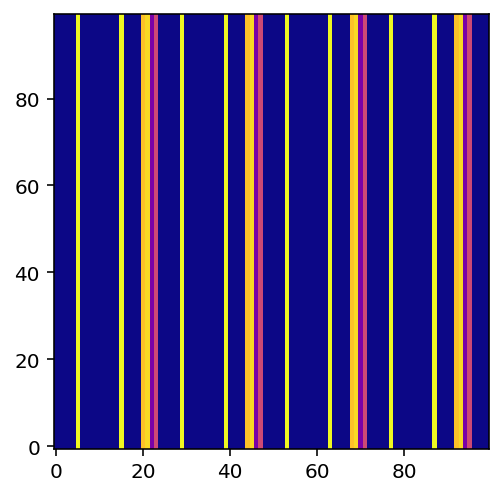

In [220]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

plot_metadata = metadata(1655991661)
plt.imshow(plot_metadata, origin='lower', cmap='plasma')
plt.show()

In [221]:
metadata(1655991661, tiled=False).shape

(24, 1)

In [200]:
import requests

key = '00fa20d9a815fab822b59c022ba8f4e5'
location = '51.87626460000001,-0.3717470999999932'
timestamp = '1655991661'
exclude = 'exclude=minutely,hourly,daily,alerts,flags'
units = 'si'
endpoint = f'https://api.darksky.net/forecast/{key}/{location},{timestamp}?{exclude}&{units}'
response = requests.get(endpoint)


In [201]:
response.json()['currently']

{'apparentTemperature': 22.06,
 'cloudCover': 0.77,
 'dewPoint': 10.97,
 'humidity': 0.49,
 'icon': 'partly-cloudy-day',
 'ozone': 347.8,
 'precipIntensity': 0,
 'precipProbability': 0,
 'pressure': 1009,
 'summary': 'Mostly Cloudy',
 'temperature': 22.06,
 'time': 1655991661,
 'uvIndex': 4,
 'visibility': 10.262,
 'windBearing': 332,
 'windGust': 8.3,
 'windSpeed': 8.02}